In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/polycystic-ovary-syndrome-pcos/PCOS_data_without_infertility.xlsx
/kaggle/input/polycystic-ovary-syndrome-pcos/PCOS_infertility.csv


In [2]:
#Importing all the libraries that I use in this project
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [3]:
#Loding data into the kernels 

file_path_with_infertility="../input/polycystic-ovary-syndrome-pcos/PCOS_infertility.csv"
file_path_without_infertility="../input/polycystic-ovary-syndrome-pcos/PCOS_data_without_infertility.xlsx"

PCOS_inf = pd.read_csv(file_path_with_infertility)
PCOS_woinf = pd.read_excel(file_path_without_infertility, sheet_name="Full_new")

**<span style="color:teal;"> Merging the two files as per patient file no. and dropping the repeated features</span>**

In [4]:
#Merging the two files as per patient file no. 
#The files were sorted into two based on patients with infertility and without infertility
data = pd.merge(PCOS_woinf,PCOS_inf, on='Patient File No.', suffixes={'','_y'},how='left')

#Dropping the repeated features after merging
data =data.drop(['Unnamed: 44', 'Sl. No_y', 'PCOS (Y/N)_y', '  I   beta-HCG(mIU/mL)_y',
       'II    beta-HCG(mIU/mL)_y', 'AMH(ng/mL)_y'], axis=1)

#Taking a look at the dataset
data.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Passing 'suffixes' as a <class 'set'>, is not supported and may give unexpected results. Provide 'suffixes' as a tuple instead. In the future a 'TypeError' will be raised.
  This is separate from the ipykernel package so we can avoid doing imports until


,Sl. No,Patient File No.,PCOS (Y/N),Age (yrs),Weight (Kg),Height(Cm),BMI,Blood Group,Pulse rate(bpm),RR (breaths/min),...,Pimples(Y/N),Fast food (Y/N),Reg.Exercise(Y/N),BP _Systolic (mmHg),BP _Diastolic (mmHg),Follicle No. (L),Follicle No. (R),Avg. F size (L) (mm),Avg. F size (R) (mm),Endometrium (mm)
0,1,1,0,28,44.6,152.0,19.300000,15,78,22,...,0,1.0,0,110,80,3,3,18.0,18.0,8.5
1,2,2,0,36,65.0,161.5,24.921163,15,74,20,...,0,0.0,0,120,70,3,5,15.0,14.0,3.7
2,3,3,1,33,68.8,165.0,25.270891,11,72,18,...,1,1.0,0,120,80,13,15,18.0,20.0,10.0
3,4,4,0,37,65.0,148.0,29.674945,13,72,20,...,0,0.0,0,120,70,2,2,15.0,14.0,7.5
4,5,5,0,25,52.0,161.0,20.060954,11,72,18,...,0,0.0,0,120,80,3,4,16.0,14.0,7.0


Everything looks alright we can work with this.

We have a dataset of shape 5 rows × 44 columns.

Let's head up to the next step and have a further look at the data.

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 541 entries, 0 to 540
Data columns (total 44 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Sl. No                  541 non-null    int64  
 1   Patient File No.        541 non-null    int64  
 2   PCOS (Y/N)              541 non-null    int64  
 3    Age (yrs)              541 non-null    int64  
 4   Weight (Kg)             541 non-null    float64
 5   Height(Cm)              541 non-null    float64
 6   BMI                     541 non-null    float64
 7   Blood Group             541 non-null    int64  
 8   Pulse rate(bpm)         541 non-null    int64  
 9   RR (breaths/min)        541 non-null    int64  
 10  Hb(g/dl)                541 non-null    float64
 11  Cycle(R/I)              541 non-null    int64  
 12  Cycle length(days)      541 non-null    int64  
 13  Marraige Status (Yrs)   540 non-null    float64
 14  Pregnant(Y/N)           541 non-null    in

**<span style="color:teal;"> Encoding categorical variables (dtype objects)</span>**

In [6]:
#Having a look at the data with dtype objects

data["AMH(ng/mL)"].head()

0    2.07
1    1.53
2    6.63
3    1.22
4    2.26
Name: AMH(ng/mL), dtype: object

In [7]:
#Similarly

data["II    beta-HCG(mIU/mL)"].head()

0      1.99
1      1.99
2    494.08
3      1.99
4    801.45
Name: II    beta-HCG(mIU/mL), dtype: object

After having a look at this info we may conclude that:

* Some numeric data are saved as strings.
* There are some missing values. Namely, Marriage Status (Yrs)& Fast food (Y/N)

In [8]:
#Dealing with categorical values.
#In this database the type objects are numeric values saved as strings.
#So I am just converting it into a numeric value.

data["AMH(ng/mL)"] = pd.to_numeric(data["AMH(ng/mL)"], errors='coerce')
data["II    beta-HCG(mIU/mL)"] = pd.to_numeric(data["II    beta-HCG(mIU/mL)"], errors='coerce')

#Dealing with missing values. 
#Filling NA values with the median of that feature.

data['Marraige Status (Yrs)'].fillna(data['Marraige Status (Yrs)'].median(),inplace=True)
data['II    beta-HCG(mIU/mL)'].fillna(data['II    beta-HCG(mIU/mL)'].median(),inplace=True)
data['AMH(ng/mL)'].fillna(data['AMH(ng/mL)'].median(),inplace=True)
data['Fast food (Y/N)'].fillna(data['Fast food (Y/N)'].median(),inplace=True)

#Clearing up the extra space in the column names (optional)

data.columns = [col.strip() for col in data.columns]

In [9]:
# Having a look at some basic statistical details.

data.describe()

,Sl. No,Patient File No.,PCOS (Y/N),Age (yrs),Weight (Kg),Height(Cm),BMI,Blood Group,Pulse rate(bpm),RR (breaths/min),...,Pimples(Y/N),Fast food (Y/N),Reg.Exercise(Y/N),BP _Systolic (mmHg),BP _Diastolic (mmHg),Follicle No. (L),Follicle No. (R),Avg. F size (L) (mm),Avg. F size (R) (mm),Endometrium (mm)
count,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,...,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000
mean,271.000000,271.000000,0.327172,31.430684,59.637153,156.484835,24.311285,13.802218,73.247689,19.243993,...,0.489834,0.515712,0.247689,114.661738,76.927911,6.129390,6.641405,15.018115,15.451701,8.475915
std,156.317519,156.317519,0.469615,5.411006,11.028287,6.033545,4.056399,1.840812,4.430285,1.688629,...,0.500359,0.500216,0.432070,7.384556,5.574112,4.229294,4.436889,3.566839,3.318848,2.165381
min,1.000000,1.000000,0.000000,20.000000,31.000000,137.000000,12.417882,11.000000,13.000000,16.000000,...,0.000000,0.000000,0.000000,12.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,136.000000,136.000000,0.000000,28.000000,52.000000,152.000000,21.641274,13.000000,72.000000,18.000000,...,0.000000,0.000000,0.000000,110.000000,70.000000,3.000000,3.000000,13.000000,13.000000,7.000000
50%,271.000000,271.000000,0.000000,31.000000,59.000000,156.000000,24.238227,14.000000,72.000000,18.000000,...,0.000000,1.000000,0.000000,110.000000,80.000000,5.000000,6.000000,15.000000,16.000000,8.500000
75%,406.000000,406.000000,1.000000,35.000000,65.000000,160.000000,26.634958,15.000000,74.000000,20.000000,...,1.000000,1.000000,0.000000,120.000000,80.000000,9.000000,10.000000,18.000000,18.000000,9.800000
max,541.000000,541.000000,1.000000,48.000000,108.000000,180.000000,38.900000,18.000000,82.000000,28.000000,...,1.000000,1.000000,1.000000,140.000000,100.000000,22.000000,20.000000,24.000000,24.000000,18.000000


In [10]:
#Added in the recent update. 
#This came upon evaluating the dataset some obvious outliers I am not explaining the process I used. 
#Dropping the outliers. 

data = data[(data["BP _Diastolic (mmHg)"]>20)]
data = data[(data["AMH(ng/mL)"]<40)]
data = data[(data["BP _Systolic (mmHg)"]>20)]
data = data[(data["Endometrium (mm)"]>0)]
data = data[(data["Avg. F size (R) (mm)"]>0)]
data = data[(data["Avg. F size (R) (mm)"]>0)]
data = data[(data["RBS(mg/dl)"]<200)]
data = data[(data["PRG(ng/mL)"]<20)]
data = data[(data["Pulse rate(bpm)"]>20)]
data = data[(data["FSH(mIU/mL)"]<4000)]
data = data[(data["LH(mIU/mL)"]<1500)]
data = data[(data["Cycle(R/I)"]<4.5)]

data.shape

(526, 44)

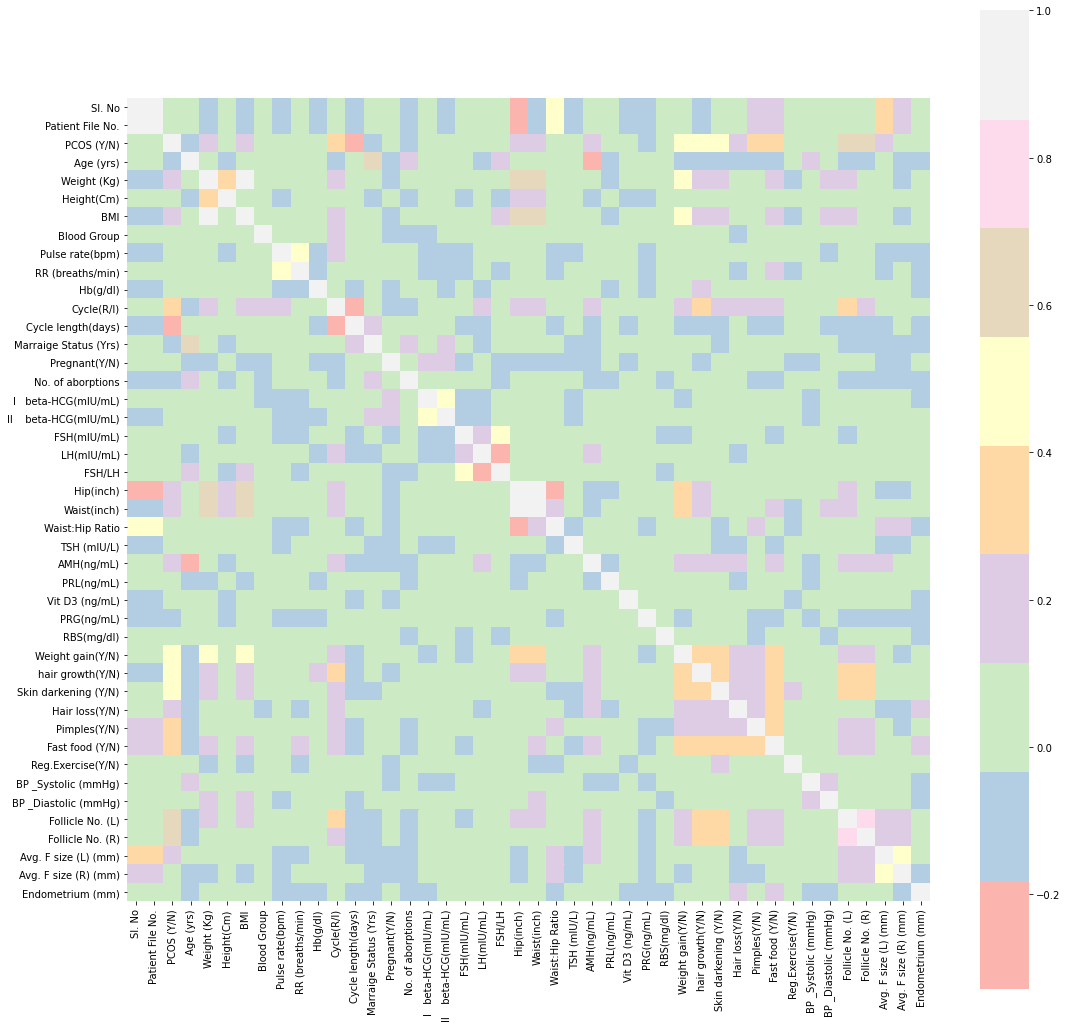

In [11]:
#Examaning a correlation matrix of all the features 

corrmat = data.corr()
plt.subplots(figsize=(18,18))
sns.heatmap(corrmat,cmap="Pastel1", square=True);

In [12]:
#How all the features correlate with the PCOS 

corrmat["PCOS (Y/N)"].sort_values(ascending=False)

PCOS (Y/N)                1.000000
Follicle No. (R)          0.650915
Follicle No. (L)          0.605305
Skin darkening (Y/N)      0.474561
hair growth(Y/N)          0.463557
Weight gain(Y/N)          0.445646
Cycle(R/I)                0.404082
Fast food (Y/N)           0.376877
Pimples(Y/N)              0.295313
AMH(ng/mL)                0.261105
Weight (Kg)               0.210241
BMI                       0.194121
Hair loss(Y/N)            0.176603
Hip(inch)                 0.163335
Waist(inch)               0.160226
Avg. F size (L) (mm)      0.124990
Pulse rate(bpm)           0.102988
LH(mIU/mL)                0.095426
Hb(g/dl)                  0.094481
Vit D3 (ng/mL)            0.086052
Endometrium (mm)          0.085608
Avg. F size (R) (mm)      0.084756
Height(Cm)                0.075431
Reg.Exercise(Y/N)         0.061816
Sl. No                    0.051936
Patient File No.          0.051936
FSH/LH                    0.043591
Blood Group               0.043032
RR (breaths/min)    

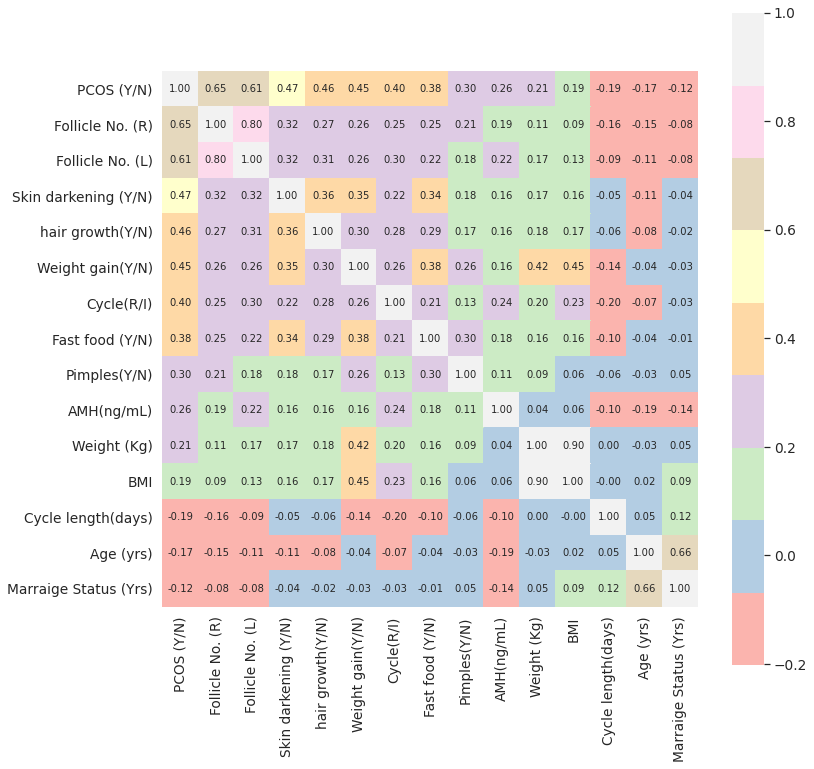

In [13]:
#Having a look at features bearing significant correlation

plt.figure(figsize=(12,12))
k = 12 #number of variables with positive for heatmap
l = 3 #number of variables with negative for heatmap
cols_p = corrmat.nlargest(k, "PCOS (Y/N)")["PCOS (Y/N)"].index 
cols_n = corrmat.nsmallest(l, "PCOS (Y/N)")["PCOS (Y/N)"].index
cols = cols_p.append(cols_n) 

cm = np.corrcoef(data[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True,cmap="Pastel1", annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

 **<span style="color:teal;"> Patterns Of Length Of The Menstrual Cycle </span>**

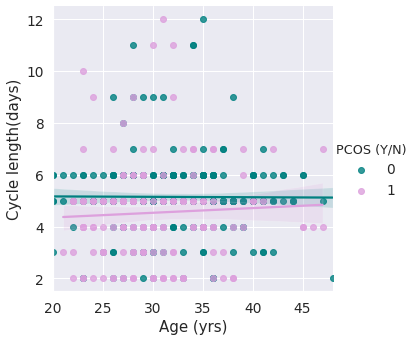

In [14]:
# Length of menstrual phase in PCOS vs normal 
color = ["teal", "plum"]
fig=sns.lmplot(data=data,x="Age (yrs)",y="Cycle length(days)", hue="PCOS (Y/N)",palette=color)
plt.show(fig)

The length of the menstrual phase is overall consistent over different ages for normal cases. Whereas in the case of PCOD the length increased with age. 

 **<span style="color:teal;"> Patterns Of BMI </span>**

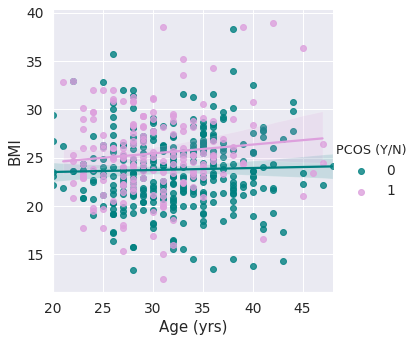

In [15]:
# Pattern of weight gain (BMI) over years in PCOS and Normal. 
fig= sns.lmplot(data =data,x="Age (yrs)",y="BMI", hue="PCOS (Y/N)", palette= color )
plt.show(fig)

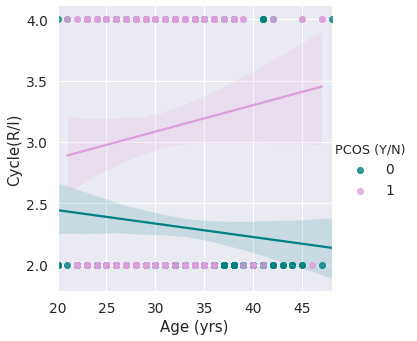

In [16]:
# cycle IR wrt age 
sns.lmplot(data =data,x="Age (yrs)",y="Cycle(R/I)", hue="PCOS (Y/N)",palette=color)
plt.show()

The mensural cycle becomes more regular for normal cases with age. Whereas, for PCOS the irregularity increases with age.

 **<span style="color:teal;"> Number Of Follicles </span>**

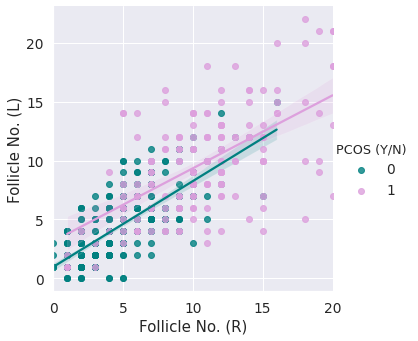

In [17]:
# Distribution of follicles in both ovaries. 
sns.lmplot(data =data,x='Follicle No. (R)',y='Follicle No. (L)', hue="PCOS (Y/N)",palette=color)
plt.show()

The distribution of follicles in both ovaries Left and Right are not equal for women with PCOS in comparison with the "Normal" patient. 
Thia is curious let's exlore it with boxen plot.

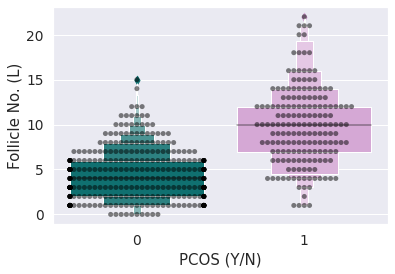

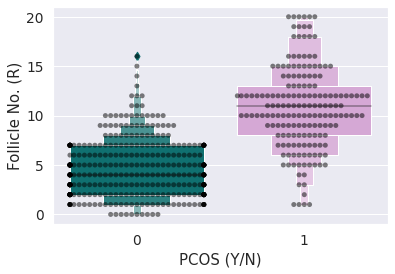

In [18]:
features = ["Follicle No. (L)","Follicle No. (R)"]
for i in features:
    sns.swarmplot(x=data["PCOS (Y/N)"], y=data[i], color="black", alpha=0.5 )
    sns.boxenplot(x=data["PCOS (Y/N)"], y=data[i], palette=color)
    plt.show()

The number of follicles in women with PCOS is higher, as expected. And are unequal as well. 
 
**<span style="color:teal;"> Some Miscellaneous EDA </span>**

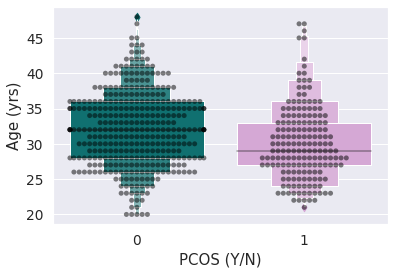

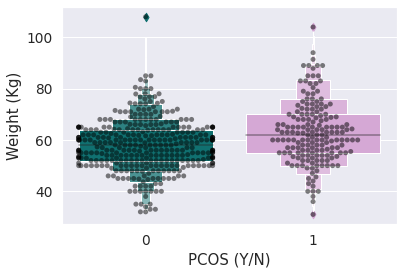

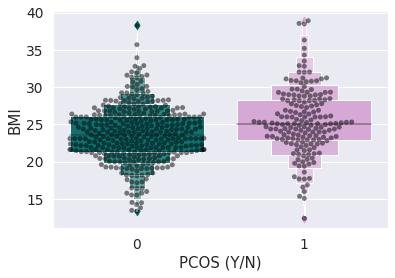

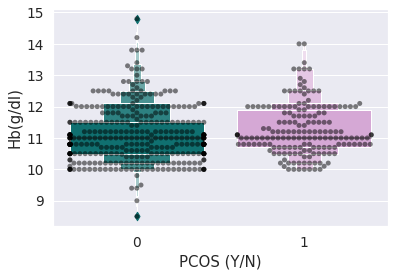

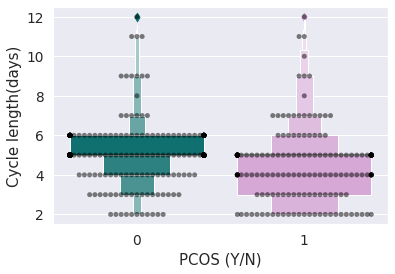

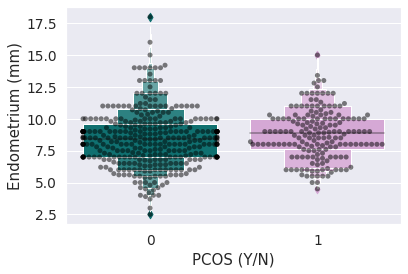

In [19]:
features = ["Age (yrs)","Weight (Kg)", "BMI", "Hb(g/dl)", "Cycle length(days)","Endometrium (mm)" ]
for i in features:
    sns.swarmplot(x=data["PCOS (Y/N)"], y=data[i], color="black", alpha=0.5 )
    sns.boxenplot(x=data["PCOS (Y/N)"], y=data[i], palette=color)
    plt.show()

In [20]:
#Assiging the features (X)and target(y)

X=data.drop(["PCOS (Y/N)","Sl. No","Patient File No."],axis = 1) #droping out index from features too
y=data["PCOS (Y/N)"]

#Splitting the data into test and training sets

X_train,X_test, y_train, y_test = train_test_split(X,y, test_size=0.3)

 **<span style="color:teal;"> Fitting the Model </span>**
 
Fitting a rather vanilla modle as base model

In [21]:
#Fitting the RandomForestClassifier to the training set

rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

#Making prediction and checking the test set

pred_rfc = rfc.predict(X_test)
accuracy = accuracy_score(y_test, pred_rfc)
print(accuracy)

0.879746835443038


In [22]:
#Building a dictionalry with list of optional values that will me analyesed by GridSearch CV

parameters = { 
    'n_estimators': [100,150, 200,500,700],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8,9,10,12],
    'criterion' :['gini', 'entropy'],
    'n_jobs':[-1,1,None]
}

#Fitting the trainingset to find parameters with best accuracy

CV_rfc = GridSearchCV(estimator=rfc, param_grid=parameters, cv= 7)
CV_rfc.fit(X_train, y_train)

#Getting the outcome of gridsearch

CV_rfc.best_params_

KeyboardInterrupt: 

In [ ]:
#Fitting the model with selected parameters

rfc1=RandomForestClassifier(**CV_rfc.best_params_)
rfc1.fit(X_train, y_train)

#Testing the Model on test set

predictions=rfc1.predict(X_test)
acccuracy_final = accuracy_score(y_test,predictions)

acccuracy_final

**<span style="color:teal;"> Classification Report & Confusion Matrix </span>**

In [ ]:
classi_report = classification_report(y_test, predictions)
print(classi_report)

In [ ]:
# cofusion matrix
plt.subplots(figsize=(15,5))
cf_matrix = confusion_matrix(y_test, predictions)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot = True, annot_kws = {'size':15}, cmap = 'Pastel1')

In [ ]:
# Importing necessary libraries for Neural Networks
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Loading Data
file_path_with_infertility = "../input/polycystic-ovary-syndrome-pcos/PCOS_infertility.csv"
file_path_without_infertility = "../input/polycystic-ovary-syndrome-pcos/PCOS_data_without_infertility.xlsx"

PCOS_inf = pd.read_csv(file_path_with_infertility)
PCOS_woinf = pd.read_excel(file_path_without_infertility, sheet_name="Full_new")

# Merging the two files as per patient file no. and dropping the repeated features
data = pd.merge(PCOS_woinf, PCOS_inf, on='Patient File No.', suffixes={'','_y'}, how='left')
data = data.drop(['Unnamed: 44', 'Sl. No_y', 'PCOS (Y/N)_y', '  I   beta-HCG(mIU/mL)_y',
                  'II    beta-HCG(mIU/mL)_y', 'AMH(ng/mL)_y'], axis=1)

# Dealing with categorical values and missing data
data["AMH(ng/mL)"] = pd.to_numeric(data["AMH(ng/mL)"], errors='coerce')
data["II    beta-HCG(mIU/mL)"] = pd.to_numeric(data["II    beta-HCG(mIU/mL)"], errors='coerce')
data['Marraige Status (Yrs)'].fillna(data['Marraige Status (Yrs)'].median(), inplace=True)
data['II    beta-HCG(mIU/mL)'].fillna(data['II    beta-HCG(mIU/mL)'].median(), inplace=True)
data['AMH(ng/mL)'].fillna(data['AMH(ng/mL)'].median(), inplace=True)
data['Fast food (Y/N)'].fillna(data['Fast food (Y/N)'].median(), inplace=True)

# Assigning features (X) and target (y)
X = data.drop(["PCOS (Y/N)", "Sl. No", "Patient File No."], axis=1)
y = data["PCOS (Y/N)"]

# Splitting the data into test and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scaling the data for better performance of the neural network
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the ANN model
model = Sequential()

# Adding input layer and first hidden layer
model.add(Dense(units=64, activation='relu', input_dim=X_train_scaled.shape[1]))

# Adding second hidden layer
model.add(Dense(units=32, activation='relu'))

# Adding the output layer (for binary classification)
model.add(Dense(units=1, activation='sigmoid'))

# Compiling the ANN
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Training the ANN on the training set
history = model.fit(X_train_scaled, y_train, batch_size=32, epochs=100, validation_split=0.2)

# Making predictions on the test set
y_pred = model.predict(X_test_scaled)
y_pred = (y_pred > 0.5)  # Convert probabilities to binary classification (0 or 1)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)

# Confusion matrix
plt.figure(figsize=(10,6))
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, annot=True, cmap="Pastel1", fmt='g')
plt.title('Confusion Matrix for ANN Model')
plt.show()


In [32]:
# Re-importing necessary libraries to ensure variables are loaded correctly
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Loading Data again for the test
file_path_with_infertility = '/kaggle/input/polycystic-ovary-syndrome-pcos/PCOS_infertility.csv'
file_path_without_infertility = '/kaggle/input/polycystic-ovary-syndrome-pcos/PCOS_data_without_infertility.xlsx'

PCOS_inf = pd.read_csv(file_path_with_infertility)
PCOS_woinf = pd.read_excel(file_path_without_infertility, sheet_name="Full_new")

# Merging the two files as per patient file no. and dropping the repeated features
data = pd.merge(PCOS_woinf, PCOS_inf, on='Patient File No.', suffixes={'','_y'}, how='left')
data = data.drop(['Unnamed: 44', 'Sl. No_y', 'PCOS (Y/N)_y', '  I   beta-HCG(mIU/mL)_y',
                  'II    beta-HCG(mIU/mL)_y', 'AMH(ng/mL)_y'], axis=1)

# Dealing with categorical values and missing data
data["AMH(ng/mL)"] = pd.to_numeric(data["AMH(ng/mL)"], errors='coerce')
data["II    beta-HCG(mIU/mL)"] = pd.to_numeric(data["II    beta-HCG(mIU/mL)"], errors='coerce')
data['Marraige Status (Yrs)'].fillna(data['Marraige Status (Yrs)'].median(), inplace=True)
data['II    beta-HCG(mIU/mL)'].fillna(data['II    beta-HCG(mIU/mL)'].median(), inplace=True)
data['AMH(ng/mL)'].fillna(data['AMH(ng/mL)'].median(), inplace=True)
data['Fast food (Y/N)'].fillna(data['Fast food (Y/N)'].median(), inplace=True)

# Assigning features (X) and target (y)
X = data.drop(["PCOS (Y/N)", "Sl. No", "Patient File No."], axis=1)
y = data["PCOS (Y/N)"]

# Splitting the data into test and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scaling the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the ANN model
model = Sequential()

# Adding input layer and first hidden layer
model.add(Dense(units=64, activation='relu', input_dim=X_train_scaled.shape[1]))

# Adding second hidden layer
model.add(Dense(units=32, activation='relu'))

# Adding the output layer
model.add(Dense(units=1, activation='sigmoid'))

# Compiling the ANN
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Training the model (for the sake of example, I will use fewer epochs)
model.fit(X_train_scaled, y_train, batch_size=32, epochs=10, validation_split=0.2)

# Now making the prediction for a single test row
single_test_data = X_test_scaled[100].reshape(1, -1)
single_prediction = model.predict(single_test_data)
single_prediction_label = "PCOS" if single_prediction > 0.5 else "No PCOS"

# Showing the actual label and the predicted label for the single test row
actual_label = y_test.iloc[100]
actual_label_str = "PCOS" if actual_label == 1 else "No PCOS"

# Displaying both actual and predicted labels
actual_label_str, single_prediction_label


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: Passing 'suffixes' as a <class 'set'>, is not supported and may give unexpected results. Provide 'suffixes' as a tuple instead. In the future a 'TypeError' will be raised.


Epoch 1/10
10/10 [==============================] - 0s 14ms/step - loss: 0.7927 - accuracy: 0.3543 - val_loss: 0.7364 - val_accuracy: 0.5526
Epoch 2/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6279 - accuracy: 0.6755 - val_loss: 0.6510 - val_accuracy: 0.6974
Epoch 3/10
10/10 [==============================] - 0s 4ms/step - loss: 0.5209 - accuracy: 0.7848 - val_loss: 0.5846 - val_accuracy: 0.7368
Epoch 4/10
10/10 [==============================] - 0s 4ms/step - loss: 0.4383 - accuracy: 0.8411 - val_loss: 0.5262 - val_accuracy: 0.7632
Epoch 5/10
10/10 [==============================] - 0s 4ms/step - loss: 0.3708 - accuracy: 0.8709 - val_loss: 0.4769 - val_accuracy: 0.7763
Epoch 6/10
10/10 [==============================] - 0s 4ms/step - loss: 0.3137 - accuracy: 0.8808 - val_loss: 0.4404 - val_accuracy: 0.8026
Epoch 7/10
10/10 [==============================] - 0s 4ms/step - loss: 0.2710 - accuracy: 0.8974 - val_loss: 0.4126 - val_accuracy: 0.8158
Epoch 8/10
10/10 [=

('No PCOS', 'No PCOS')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: Passing 'suffixes' as a <class 'set'>, is not supported and may give unexpected results. Provide 'suffixes' as a tuple instead. In the future a 'TypeError' will be raised.


[08:13:33] WARNING: ../src/learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy: 0.8773006134969326
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.93      0.91       110
           1       0.84      0.77      0.80        53

    accuracy                           0.88       163
   macro avg       0.87      0.85      0.86       163
weighted avg       0.88      0.88      0.88       163



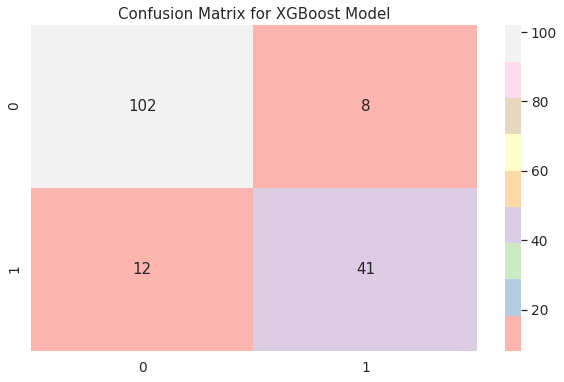

Actual Label: No PCOS
Predicted Label: PCOS
Prediction Probabilities: [[0.41195703 0.588043  ]]


In [38]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb

# Loading Data
file_path_with_infertility = "/kaggle/input/polycystic-ovary-syndrome-pcos/PCOS_infertility.csv"
file_path_without_infertility = "/kaggle/input/polycystic-ovary-syndrome-pcos/PCOS_data_without_infertility.xlsx"

PCOS_inf = pd.read_csv(file_path_with_infertility)
PCOS_woinf = pd.read_excel(file_path_without_infertility, sheet_name="Full_new")

# Merging the two files as per patient file no. and dropping the repeated features
data = pd.merge(PCOS_woinf, PCOS_inf, on='Patient File No.', suffixes={'','_y'}, how='left')
data = data.drop(['Unnamed: 44', 'Sl. No_y', 'PCOS (Y/N)_y', '  I   beta-HCG(mIU/mL)_y',
                  'II    beta-HCG(mIU/mL)_y', 'AMH(ng/mL)_y'], axis=1)

# Dealing with categorical values and missing data
data["AMH(ng/mL)"] = pd.to_numeric(data["AMH(ng/mL)"], errors='coerce')
data["II    beta-HCG(mIU/mL)"] = pd.to_numeric(data["II    beta-HCG(mIU/mL)"], errors='coerce')
data['Marraige Status (Yrs)'].fillna(data['Marraige Status (Yrs)'].median(), inplace=True)
data['II    beta-HCG(mIU/mL)'].fillna(data['II    beta-HCG(mIU/mL)'].median(), inplace=True)
data['AMH(ng/mL)'].fillna(data['AMH(ng/mL)'].median(), inplace=True)
data['Fast food (Y/N)'].fillna(data['Fast food (Y/N)'].median(), inplace=True)

# Assigning features (X) and target (y)
X = data.drop(["PCOS (Y/N)", "Sl. No", "Patient File No."], axis=1)
y = data["PCOS (Y/N)"]

# Splitting the data into test and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scaling the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert the scaled data back to a DataFrame (optional for interpretability)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

# Initialize the XGBoost classifier
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Train the model on the training data
xgb_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = xgb_model.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)

# Confusion matrix
plt.figure(figsize=(10,6))
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, annot=True, cmap="Pastel1", fmt='g')
plt.title('Confusion Matrix for XGBoost Model')
plt.show()

# Show the actual and predicted value for a single test row
# Show the actual and predicted value for a single test row
single_test_index = 0  # You can choose any index from the test set
single_test_data = X_test_scaled.iloc[single_test_index:single_test_index+1]

# Predicting the probability for the single test row
single_prediction_prob = xgb_model.predict_proba(single_test_data)
single_prediction_label = "PCOS" if single_prediction_prob[0][1] > 0.5 else "No PCOS"

# Getting the actual label for the same test row
actual_label = y_test.iloc[single_test_index]
actual_label_str = "PCOS" if actual_label == 1 else "No PCOS"

# Displaying both actual and predicted labels with probability
print(f"Actual Label: {actual_label_str}")
print(f"Predicted Label: {single_prediction_label}")
print(f"Prediction Probabilities: {single_prediction_prob}")

